In [1]:
import json
import os
import pathlib
import time

import numpy as np
import rasterio
from rasterio.plot import show
import requests
from requests.auth import HTTPBasicAuth

# The 8 sensor locations used for this research.
CAMS = [0,1,2,3,4,5,6,7];
CAMS[0] = ['1604', -97.6649360, 29.8649170];
CAMS[1] = ['6602', -97.5417940, 30.5457060];
CAMS[2] = ['1612', -97.2937410, 30.1082220];
CAMS[3] = ['0614', -98.0833473, 30.2146162];
CAMS[4] = ['1613', -97.3785080, 30.3478080];
CAMS[5] = ['1675', -97.9288560, 29.8622810];
CAMS[6] = ['1603', -97.8937440, 30.2163970];
CAMS[7] = ['0690', -97.7345790, 30.6664421];

# Set your Planet Lab API Key if you have not already.
os.environ['PL_API_KEY']='222f5fae886d4c4d856bd52e22db62be'

# API Key stored as an env variable
PLANET_API_KEY = os.getenv('PL_API_KEY')

# Search parameters
## The type of band procured.
item_type = "PSScene4Band"
## The radius of the search box in decimal degrees.
size = .05;
## The year of the search.
year = 2018;
## The maximum amount of cloud cover allowed per image.
cloud_cover_lte = .01;

In [2]:
# This function takes coordinates and a size (in degrees) to create a geojson bounding box.
def get_bounding_box(coordinates, size):
    # Bounding Box around a CAMS.
    geojson_geometry = {
      "type": "Polygon",
      "coordinates": [
        [ 
          [coordinates[1] - size, coordinates[2] + size],
          [coordinates[1] + size, coordinates[2] + size],
          [coordinates[1] + size, coordinates[2] - size],
          [coordinates[1] - size, coordinates[2] - size],
          [coordinates[1] - size, coordinates[2] + size]
        ]
      ]
    }
    return geojson_geometry

# This function takes the Area of Interest (AOI), year, month, and desired cloud cover parameter to create a combined filter. 
def create_filter(AOI, year, month, lte_clouds):
    geometry_filter = {
      "type": "GeometryFilter",
      "field_name": "geometry",
      "config": AOI
    }

    if month <= 9:
        gte_date = str(year) + '-0' + str(month) + '-01T00:00:00.000Z';
        if month == 9:
            lte_date = str(year) + '-' + str(month+1) + '-01T00:00:00.000Z';
        else:
            lte_date = str(year) + '-0' + str(month+1) + '-01T00:00:00.000Z';
    elif month > 9 & i <= 99:
        gte_date = str(year) + '-' + str(month) + '-01T00:00:00.000Z';
        if month == 12:
            lte_date = str(year + 1) + '-01-01T00:00:00.000Z';
        else:
            lte_date = str(year) + "-" + str(month+1) + '-01T00:00:00.000Z';
    
    # get images acquired within a date range
    date_range_filter = {
      "type": "DateRangeFilter",
      "field_name": "acquired",
      "config": {
        "gte": gte_date,
        "lte": lte_date
      }
    }

    # only get images which have less than 1% cloud coverage
    cloud_cover_filter = {
      "type": "RangeFilter",
      "field_name": "cloud_cover",
      "config": {
        "lte": lte_clouds
      }
    }

    # combine our geo, date, cloud filters
    combined_filter = {
      "type": "AndFilter",
      "config": [geometry_filter, date_range_filter, cloud_cover_filter]
    }
    
    return combined_filter

In [3]:
for i in range(0,8):
    geojson_geometry = get_bounding_box(CAMS[i], size)
    for month in range(1,13):
        combined_filter = create_filter(geojson_geometry, year, month, cloud_cover_lte)

In [40]:
for i in range(0,1):
    geojson_geometry = get_bounding_box(CAMS[i], size)
    for month in range(1,13):
        year = 2018
        cloud_cover_lte = .01
        combined_filter = create_filter(geojson_geometry, year, month, cloud_cover_lte)
        print('CAMS-' + str(CAMS[i][0]) + ", " + str(month) + "-" + str(year))
        # API request object
        search_request = {
          "interval": "day",
          "item_types": [item_type], 
          "filter": combined_filter
        }
        # fire off the POST request
        search_result = \
          requests.post(
            'https://api.planet.com/data/v1/quick-search',
            auth=HTTPBasicAuth(PLANET_API_KEY, ''),
            json=search_request)
        
        # extract image IDs
        image_ids = [feature['id'] for feature in search_result.json()['features']]
        # extract the origin_x and origin_y
        origin_x = [feature['properties']['origin_x'] for feature in search_result.json()['features']]
        origin_y = [feature['properties']['origin_y'] for feature in search_result.json()['features']]
        epsg_code = [feature['properties']['epsg_code'] for feature in search_result.json()['features']]

        print(len(image_ids))
        print(image_ids)
        print(origin_x)
        print(origin_y)
        print(epsg_code)

CAMS-1604, 1-2018
12
['20180131_200511_0c38', '20180130_163302_1022', '20180130_163301_1022', '20180122_163309_0f18', '20180122_163308_0f18', '20180114_171411_0f2e', '20180114_171410_0f2e', '20180114_163226_102f', '20180114_163225_102f', '20180114_163224_102f', '20180108_163316_0f42', '20180108_163314_0f42']
[622428, 632373, 633801, 614868, 616299, 628071, 629487, 620313, 621762, 623166, 609477, 612384]
[3322110, 3302592, 3309825, 3307377, 3314568, 3321729, 3314868, 3305100, 3312342, 3319518, 3304257, 3318825]
[32614, 32614, 32614, 32614, 32614, 32614, 32614, 32614, 32614, 32614, 32614, 32614]
CAMS-1604, 2-2018
0
[]
[]
[]
[]
CAMS-1604, 3-2018
16
['20180330_163527_1038', '20180330_163526_1038', '20180330_163525_1038', '20180320_163423_1029', '20180320_163421_1029', '20180320_163551_102c', '20180320_163550_102c', '20180320_163549_102c', '20180319_163616_0f22', '20180319_163615_0f22', '20180319_163614_0f22', '20180320_163422_1029', '20180312_163517_1036', '20180312_163516_1036', '20180306

In [36]:
# For demo purposes, just grab the first image ID
id0 = '20180131_200511_0c38'
id0_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(item_type, id0)

# Returns JSON metadata for assets in this ID. Learn more: planet.com/docs/reference/data-api/items-assets/#asset
result = \
  requests.get(
    id0_url,
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )

# List of asset types available for this particular satellite image
print(result.json().keys())

dict_keys(['analytic', 'analytic_dn', 'analytic_dn_xml', 'analytic_xml', 'basic_analytic', 'basic_analytic_dn', 'basic_analytic_dn_nitf', 'basic_analytic_dn_rpc', 'basic_analytic_dn_rpc_nitf', 'basic_analytic_dn_xml', 'basic_analytic_dn_xml_nitf', 'basic_analytic_nitf', 'basic_analytic_rpc', 'basic_analytic_rpc_nitf', 'basic_analytic_xml', 'basic_analytic_xml_nitf', 'basic_udm', 'udm'])


In [23]:
# Use the version 2 of orders API to clip images to the area of interest after item id acquisition.
orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# set up requests to work with api
auth = HTTPBasicAuth(PLANET_API_KEY, '')
headers = {'content-type': 'application/json'}

# define products part of order
single_product = [
    {
      "item_ids": ["20181213_164549_0f4e"],
      "item_type": "PSScene4Band",
      "product_bundle": "analytic"
    }
]

In [24]:
# define helpful functions for submitting, polling, and downloading an order
def place_order(request, auth):
    response = requests.post(orders_url, data=json.dumps(request), auth=auth, headers=headers)
    print(response)
    
    if not response.ok:
        raise Exception(response.content)

    order_id = response.json()['id']
    print(order_id)
    order_url = orders_url + '/' + order_id
    return order_url

def poll_for_success(order_url, auth, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        r = requests.get(order_url, auth=auth)
        response = r.json()
        state = response['state']
        print(state)
        success_states = ['success', 'partial']
        if state == 'failed':
            raise Exception(response)
        elif state in success_states:
            break
        
        time.sleep(10)
        
def download_order(order_url, auth, overwrite=False):
    r = requests.get(order_url, auth=auth)
    print(r)

    response = r.json()
    results = response['_links']['results']
    results_urls = [r['location'] for r in results]
    results_names = [r['name'] for r in results]
    results_paths = [pathlib.Path(os.path.join('data', n)) for n in results_names]
    print('{} items to download'.format(len(results_urls)))
    
    for url, name, path in zip(results_urls, results_names, results_paths):
        if overwrite or not path.exists():
            print('downloading {} to {}'.format(name, path))
            r = requests.get(url, allow_redirects=True)
            path.parent.mkdir(parents=True, exist_ok=True)
            open(path, 'wb').write(r.content)
        else:
            print('{} already exists, skipping {}'.format(path, name))
            
    return dict(zip(results_names, results_paths))

# define helpful functions for visualizing downloaded imagery
def show_rgb(img_file):
    with rasterio.open(img_file) as src:
        b,g,r,n = src.read()

    rgb = np.stack((r,g,b), axis=0)
    show(rgb/rgb.max())
    
def show_gray(img_file):
    with rasterio.open(img_file) as src:
        g = src.read(1)
    show(g/g.max())
    
# define the clip tool
clip = {
    "clip": {
        "aoi": geojson_geometry
    }
}

# create an order request with the clipping tool
request_clip = {
  "name": "first clip",
  "products": single_product,
  "tools": [clip]
}

# allow for caching so we don't always run clip
run_clip = True

clip_img_file = 'data/6c23f9e1-d86a-47fe-9eb2-2693196168e0/1/files/20181213_164549_0f4e_3B_AnalyticMS_clip.tif'
if os.path.isfile(clip_img_file): run_clip = False

In [28]:
if run_clip:
    clip_order_url = place_order(request_clip, auth)
    poll_for_success(clip_order_url, auth)
    downloaded_clip_files = download_order(clip_order_url, auth)
    clip_img_file = next(downloaded_clip_files[d] for d in downloaded_clip_files
                     if d.endswith('_3B_AnalyticMS_clip.tif'))
clip_img_file

<Response [202]>
e02e560e-90f9-442f-bffd-c108cb8c8db4
queued
queued
queued
queued
queued
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
success
<Response [200]>
5 items to download
downloading e02e560e-90f9-442f-bffd-c108cb8c8db4/1/manifest.json to data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/manifest.json
downloading e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_DN_udm_clip.tif to data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_DN_udm_clip.tif
downloading e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_metadata_clip.xml to data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_metadata_clip.xml
downloading e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_clip.tif to data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/file

PosixPath('data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_clip.tif')

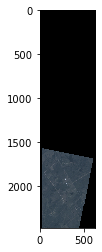

In [35]:
# Display the results.
show_rgb('data/e02e560e-90f9-442f-bffd-c108cb8c8db4/1/files/20181213_164549_0f4e_3B_AnalyticMS_clip.tif')